In [155]:
#import packages
import pandas as pd  #for Dataframe and data manipulations
import numpy as np  #Provides array objects
from numpy import savetxt
import gzip  #For unzipping the input customer review files
import re  #For regular expression usage
import seaborn as sns  #For visualization like data distribution matrix
import nltk  #Natrual language toolkit
import matplotlib.pyplot as plt

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn import model_selection
from sklearn.model_selection import train_test_split
import tensorflow as tf  #TensorFlow Package
import keras  #Neural network API
from tensorflow import keras
from keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer  #Convert input text to tokens
from tensorflow.keras.callbacks import EarlyStopping  #Stop training at a threshold
from tensorflow.keras.models import load_model  #load a saved model
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences  #For padding of text
from sklearn.model_selection import GridSearchCV


from nltk.corpus import stopwords #For stopword usage
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/henry.hartzler/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/henry.hartzler/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/henry.hartzler/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/henry.hartzler/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [156]:
#Load text files from UCI Sentiment Labeled Sentences Dataset
df = pd.read_csv('/Users/henry.hartzler/Desktop/sentiment labelled sentences/amazon_cells_labelled.txt', delimiter='\t', header=None)
df.columns = ['review', 'sentiment']

In [157]:
#Preview Merged Dataframe
df.head(10)

,review,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
5,I have to jiggle the plug to get it to line up...,0
6,If you have several dozen or several hundred c...,0
7,If you are Razr owner...you must have this!,1
8,"Needless to say, I wasted my money.",0
9,What a waste of money and time!.,0


In [158]:
#View Shape of Data 
df.shape

(1000, 2)

In [159]:
df.describe()

,sentiment
count,1000.00000
mean,0.50000
std,0.50025
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [160]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     1000 non-null   object
 1   sentiment  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


<AxesSubplot:xlabel='sentiment', ylabel='count'>

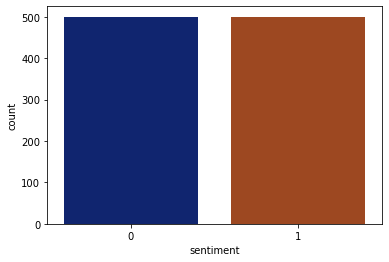

In [161]:
#Verify the distribution of data
sns.countplot(data=df, x='sentiment', palette='dark')

In [162]:
#Check for special/unusual characters. (Festus, 2022)
characters = df['review']
list_of_characters = []
for c in characters: 
    for x in c: 
        if x not in list_of_characters:
            list_of_characters.append(x)
            
print(list_of_characters)

['S', 'o', ' ', 't', 'h', 'e', 'r', 'i', 's', 'n', 'w', 'a', 'y', 'f', 'm', 'p', 'l', 'u', 'g', 'U', 'I', 'b', 'c', 'v', '.', 'G', 'd', ',', 'E', 'x', 'j', 'T', '4', '5', 'M', 'A', 'J', 'O', 'R', 'P', 'B', 'L', '!', 'z', 'N', 'W', 'q', 'H', '+', 'V', '"', 'Y', 'D', 'F', 'k', "'", 'K', 'C', '/', '7', '3', '6', '8', '0', '2', '?', 'Z', '-', '1', ':', ')', '(', 'Q', '&', '$', '*', ';', 'X', '%', '9', '#', '[', ']']


In [163]:
#Standardizing Text (Festus, 2022)
description_list = []
stop_words = stopwords.words('english')
for description in df.review: 
    #Remove all characters except letters
    description = re.sub('[^a-zA-Z]', ' ', description) 
    #Convert to lower case
    description = description.lower() 
    #Perform tokenization
    description = nltk.word_tokenize(description) 
    #Perform lemmatization
    lemma = nltk.WordNetLemmatizer()
    description = [lemma.lemmatize(word) for word in description]
    #Remove stopwords
    description = [word for word in description if not word in stop_words]
    description = ' '.join(description)
    description_list.append(description)

#Preview List 
description_list[0:10]

['way plug u unless go converter',
 'good case excellent value',
 'great jawbone',
 'tied charger conversation lasting minute major problem',
 'mic great',
 'jiggle plug get line right get decent volume',
 'several dozen several hundred contact imagine fun sending one one',
 'razr owner must',
 'needle say wasted money',
 'waste money time']

In [164]:
#Identify vocabulary size (Festus, 2022)
tok = Tokenizer()
tok.fit_on_texts(df['review'])
vocab_size = len(tok.word_index) +1
print('Vocabulary Size: ', vocab_size)

Vocabulary Size:  1879


In [165]:
#Proposed Word Embedding Length (Festus, 2022)
max_sequence_embedding = int(round(np.sqrt(np.sqrt(vocab_size)), 0))
print('Proposed Word Embedding Length: ', max_sequence_embedding)

Proposed Word Embedding Length:  7


In [166]:
#Maximum sequence length (Festus, 2022)
sequence_length = []
for char_len in df['review']:
    sequence_length.append(len(char_len.split(' ')))
    
sequence_max = np.max(sequence_length)
sequence_min = np.min(sequence_length)
sequence_median = np.median(sequence_length)

print('The maximum length of our sequences would be: ', sequence_max)
print('The minimum length of our sequences would be: ', sequence_min)
print('The median length of our sequences would be: ', sequence_median)

The maximum length of our sequences would be:  30
The minimum length of our sequences would be:  1
The median length of our sequences would be:  9.0


In [167]:
#Split data into Train and Test Datasets 
sentiment_list = df["sentiment"].values.tolist()

X = np.array(description_list)
y = np.array(sentiment_list)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40, stratify=y)

print('Shape of orignal dataset: ', df.shape)
print('Shape of input - training set: ', X_train.shape)
print('Shape of output - training set: ', y_train.shape)
print('Shape of input - testing set: ', X_test.shape)
print('Shape of output - testing set: ', y_test.shape)

Shape of orignal dataset:  (1000, 2)
Shape of input - training set:  (800,)
Shape of output - training set:  (800,)
Shape of input - testing set:  (200,)
Shape of output - testing set:  (200,)


In [168]:
#Save Train and Test Datasets as CSV files 
savetxt('/Users/henry.hartzler/Desktop/X_train.csv', X_train, delimiter=' ', fmt='%s')
savetxt('/Users/henry.hartzler/Desktop/y_train.csv', y_train, delimiter=' ', fmt='%s')
savetxt('/Users/henry.hartzler/Desktop/X_test.csv', X_test, delimiter=' ', fmt='%s')
savetxt('/Users/henry.hartzler/Desktop/y_test.csv', y_test, delimiter=' ', fmt='%s')

In [169]:
#Normalize text using Tokenization (Festus, 2022) (2019)
tokenizer = Tokenizer(num_words=vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print(word_index)

{'OOV': 1, 'phone': 2, 'great': 3, 'wa': 4, 'work': 5, 'good': 6, 'headset': 7, 'quality': 8, 'product': 9, 'battery': 10, 'sound': 11, 'well': 12, 'use': 13, 'one': 14, 'ear': 15, 'like': 16, 'ha': 17, 'would': 18, 'case': 19, 'time': 20, 'price': 21, 'get': 22, 'really': 23, 'recommend': 24, 'doe': 25, 'excellent': 26, 'call': 27, 'love': 28, 'make': 29, 'best': 30, 'charger': 31, 'nice': 32, 'fit': 33, 'new': 34, 'problem': 35, 'item': 36, 'service': 37, 'look': 38, 'also': 39, 'easy': 40, 'car': 41, 'ever': 42, 'worked': 43, 'bluetooth': 44, 'year': 45, 'bought': 46, 'even': 47, 'money': 48, 'charge': 49, 'first': 50, 'used': 51, 'comfortable': 52, 'buy': 53, 'could': 54, 'better': 55, 'reception': 56, 'still': 57, 'happy': 58, 'long': 59, 'poor': 60, 'two': 61, 'purchase': 62, 'cell': 63, 'last': 64, 'day': 65, 'life': 66, 'camera': 67, 'piece': 68, 'using': 69, 'worst': 70, 'volume': 71, 'made': 72, 'hear': 73, 'right': 74, 'clear': 75, 'far': 76, 'bad': 77, 'screen': 78, 'people

In [170]:
#Padding Process (Festus, 2022)
#Train 
sequences_train = tokenizer.texts_to_sequences(X_train)
padded_train = pad_sequences(sequences_train, maxlen=sequence_max, padding='post', truncating='post')

#Test
sequences_test = tokenizer.texts_to_sequences(X_test)
padded_test = pad_sequences(sequences_test, maxlen=sequence_max, padding='post', truncating='post')

#Display the Padded Sequence 
print(padded_train.shape)
print(padded_train)

(800, 30)
[[366   6 193 ...   0   0   0]
 [570 367   3 ...   0   0   0]
 [ 33 256 194 ...   0   0   0]
 ...
 [  6   5  90 ...   0   0   0]
 [128 352   0 ...   0   0   0]
 [229 295 253 ...   0   0   0]]


In [171]:
#NN to preform Sentiment Analysis (Festus, 2022)
activation = 'softmax'
loss = 'sparse_categorical_crossentropy'
optimizer = 'adam' 
embedding_dim = 16

num_epochs = 20

#Define early stopping monitor 
early_stopping_monitor = EarlyStopping(patience=2)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=sequence_max), 
    tf.keras.layers.GlobalAveragePooling1D(), 
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(2, activation=activation)
])
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

#Print Model Summary 
print(model.summary())

history = model.fit(padded_train, y_train, batch_size=32, epochs=num_epochs, 
                    validation_split=0.2, callbacks=[early_stopping_monitor], verbose=True)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 30, 16)            30064     
                                                                 
 global_average_pooling1d_7   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_21 (Dense)            (None, 100)               1700      
                                                                 
 dense_22 (Dense)            (None, 50)                5050      
                                                                 
 dense_23 (Dense)            (None, 2)                 102       
                                                                 
Total params: 36,916
Trainable params: 36,916
Non-trainable params: 0
__________________________________________________

In [172]:
#Verification of model accuracy (Festus, 2022)
score = model.evaluate(padded_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.40722519159317017 / Test accuracy: 0.7950000166893005


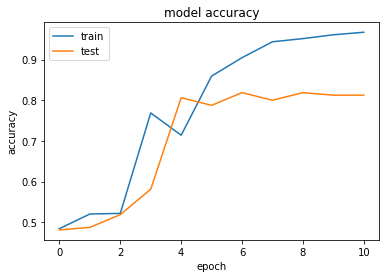

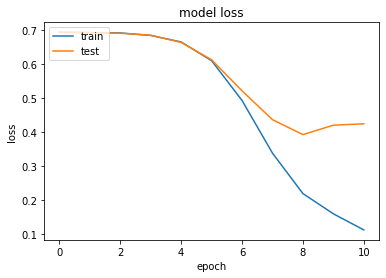

In [173]:
#Visulization of summary history for accuracy (Brownlee, 2016)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#Visulization of summary history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [174]:
#Perform Predictions on the model
predictions = model.predict(padded_test)

7/7 [==============================] - 0s 3ms/step


In [175]:
#Verify the predicted sentiment by comparing to actual label from test date
L = 9 
print('Predicted Review Text: ', X_test[L], '\n')
print('Predicted: ', 'negative' if predictions[L][0] != 0.5 else 'positive', 'review')
print('Actual: ', 'negative' if y_test[L] == 0 else 'positive', 'review')

Predicted Review Text:  however keypad tinny sometimes reach wrong button 

Predicted:  negative review
Actual:  negative review


In [176]:
#Save the model
model.save('model.h5')